# Blind Docking

In [1]:
from pymol import cmd
import py3Dmol

from vina import Vina

import pandas as pd
import numpy as np

from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem,rdFMCS, Draw

from meeko import MoleculePreparation
from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import prolif as plf
from prolif.plotting.network import LigNetwork


import sys, os, random
sys.path.insert(1, 'utilities/')

from multiprocessing import Process

from utils import fix_protein, getbox, generate_ledock_file, dok_to_sdf, get_3D_view

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

In [2]:
os.chdir('test/Blind_Docking/')

In [3]:
cmd.fetch(code='1XOZ',type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='Lig',selection='organic')
cmd.save(filename='1XOZ_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename='1XOZ_lig.mol2',format='mol2',selection='Lig')
cmd.delete('all')

 PyMOL not running, entering library mode (experimental)


In [4]:
fix_protein(filename='1XOZ_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output='1XOZ_clean_H.pdb')

RDKit WARNING: [19:56:14] 1XOZ: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit ERROR: [19:56:14] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit ERROR: 


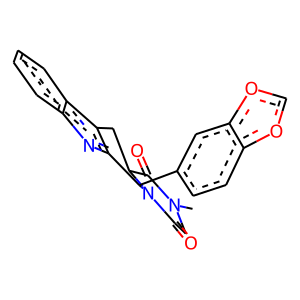

In [5]:
m=Chem.MolFromMol2File('1XOZ_lig.mol2',False)
Draw.MolToImage(m)

In [6]:
mol= [m for m in pybel.readfile(filename='1XOZ_lig.mol2',format='mol2')][0]
mol.addh()
out=pybel.Outputfile(filename='1XOZ_lig_H.mol2',format='mol2',overwrite=True)
out.write(mol)
out.close()

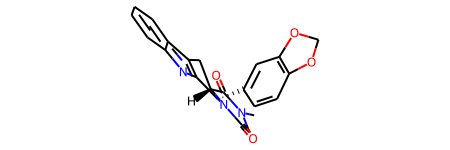

In [7]:
m=Chem.MolFromMol2File('1XOZ_lig_H.mol2')
m

In [8]:
get_3D_view(receptor_file='1XOZ_clean_H.pdb',rec_opts={'format': 'pdb'},refMol='1XOZ_lig_H.mol2',refMol_opts={'format': 'mol2'})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
!../../bin/prepare_receptor -v -r 1XOZ_clean_H.pdb -A hydrogens -o 1XOZ_clean_H.pdbqt

set verbose to  True
set receptor_filename to  1XOZ_clean_H.pdb
set repairs to  hydrogens
set outputfilename to  1XOZ_clean_H.pdbqt
read  1XOZ_clean_H.pdb
setting up RPO with mode= automatic and outputfilename=  1XOZ_clean_H.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide
Sorry, there are no Gasteiger parameters available for atom 1XOZ_clean_H:A:GLU326:OXT


In [10]:
results = [m for m in pybel.readfile(filename='1XOZ_lig_H.mol2',format='mol2')]
out=pybel.Outputfile(filename='1XOZ_lig_H.pdbqt',format='pdbqt',overwrite=True)
for pose in results:
    pose.addh()
    out.write(pose)
out.close()

In [11]:
!../../bin/fpocket -f 1XOZ_clean_H.pdb -d > pocket_descriptors.csv

In [12]:
descriptors_data=pd.read_csv('pocket_descriptors.csv',sep=' ',index_col=[0])
descriptors_data

,drug_score,volume,nb_asph,inter_chain,apol_asph_proportion,mean_asph_radius,as_density,mean_asph_solv_acc,mean_loc_hyd_dens,flex,...,val,trp,tyr,chain_1_type,chain_2_type,num_res_chain_1,num_res_chain_2,lig_het_tag,name_chain_1,name_chain_2
cav_id,,,,,,,,,,,,,,,,,,,,,
1,0.8741,1037.6335,139,0,0.6331,4.0200,6.8663,0.4647,60.2955,0.0,...,0,1,2,0,0,325,325,NaN,A,A
2,0.0452,593.0098,72,0,0.3333,3.7437,5.5621,0.4716,19.5833,0.0,...,0,1,0,0,0,325,325,NaN,A,A
3,0.0003,486.5075,37,0,0.3243,4.0605,5.1642,0.5894,10.6667,0.0,...,0,0,1,0,0,325,325,NaN,A,A
4,0.0021,368.9630,30,0,0.4667,3.9872,4.2452,0.6120,11.7143,0.0,...,0,0,0,0,0,325,325,NaN,A,A
5,0.0009,105.3742,23,0,0.3913,3.5100,2.0155,0.3504,8.0000,0.0,...,0,0,0,0,0,325,325,NaN,A,A
6,0.0046,230.9206,34,0,0.4706,3.8398,3.2787,0.4623,15.0000,0.0,...,0,1,0,0,0,325,325,NaN,A,A
7,0.0005,227.3969,16,0,0.6250,3.9238,2.4631,0.6783,9.0000,0.0,...,0,0,0,0,0,325,325,NaN,A,A
8,0.0004,215.7399,15,0,0.2667,3.9367,2.9664,0.5179,3.0000,0.0,...,0,1,0,0,0,325,325,NaN,A,A
9,0.0012,262.7325,33,0,0.6061,4.1402,2.1593,0.6400,19.0000,0.0,...,0,0,0,0,0,325,325,NaN,A,A


In [13]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
#view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1XOZ_lig_H.mol2','r').read(),'mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.1}})


for file in os.listdir(path='1XOZ_clean_H_out/'):
    if '.pqr' in file:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(open('1XOZ_clean_H_out/'+file,'r').read(),'pqr')
        x = view.getModel()
        x.setStyle({},{'sphere':{'color':color[0],'opacity':0.8}})   

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
box_table=pd.DataFrame()
for file in os.listdir('1XOZ_clean_H_out/'):
    if 'pqr' in file:
        pocket_num=int(file.split('_')[0].replace('pocket',''))
        cmd.load(filename='1XOZ_clean_H_out/'+file,format='pqr',object=pocket_num)
        
        center,size=getbox(selection=pocket_num,extending=5.0,software='vina')
        box_table.loc[pocket_num,'center_x']=center['center_x']
        box_table.loc[pocket_num,'center_y']=center['center_y']
        box_table.loc[pocket_num,'center_z']=center['center_z']
        
        box_table.loc[pocket_num,'size_x']=size['size_x']
        box_table.loc[pocket_num,'size_y']=size['size_y']
        box_table.loc[pocket_num,'size_z']=size['size_z']
        
        cmd.delete('all')
box_table.sort_index(inplace=True)

In [15]:
box_table

,center_x,center_y,center_z,size_x,size_y,size_z
1,47.153002,36.187000,15.229000,20.326000,18.056000,24.312000
2,39.917500,46.822001,12.002500,18.320999,23.436001,15.865001
3,24.391001,19.912000,19.753000,18.076000,18.219999,19.172001
4,26.427000,30.581500,35.598000,17.528000,16.167002,16.634003
5,33.264500,32.007500,29.854000,13.457001,13.223000,11.883999
6,38.223499,29.394000,29.178499,11.913002,12.837999,17.578999
7,35.526501,15.045000,26.638000,15.500999,11.122000,12.118000
8,28.457500,48.134499,40.513498,14.118999,13.151001,14.659000
9,33.537000,17.919500,15.523000,14.968000,13.763000,13.890000
10,29.666999,36.083000,3.642500,24.199999,15.599998,19.619000


In [19]:
from multiprocessing import Process
import os

def vina(receptor='',ligand='',center=[0,0,0],size=[0,0,0],exhaustiveness=8,n_poses=10,output=''):
    v = Vina(sf_name='vina')

    v.set_receptor(receptor)

    v.set_ligand_from_file(ligand)

    v.compute_vina_maps(center=center, box_size=size)

    v.dock(exhaustiveness=exhaustiveness, n_poses=n_poses)
    v.write_poses(output, n_poses=n_poses, overwrite=True)

In [21]:
for pocket in box_table.index:
    p = Process(target=vina, args=('1XOZ_clean_H.pdbqt','1XOZ_lig_H.pdbqt',
                                   [box_table.loc[pocket,'center_x'],box_table.loc[pocket,'center_y'],box_table.loc[pocket,'center_z']],
                                  [box_table.loc[pocket,'size_x'],box_table.loc[pocket,'size_y'],box_table.loc[pocket,'size_z']],
                                   8,
                                   5,
                                  '1XOZ_vina_pock_'+str(pocket)+'.pdbqt'))
    p.start()
    p.join()

In [25]:
for file in os.listdir('../Blind_Docking/'):
    if 'vina' in file:
        results = [m for m in pybel.readfile(filename=file,format='pdbqt')]
        out=pybel.Outputfile(filename=file.replace('pdbqt','sdf'),format='sdf',overwrite=True)
        for pose in results:
            pose.addh()
            out.write(pose)
        out.close()

In [29]:
all_mols=[]
for file in os.listdir('../Blind_Docking/'):
    if 'vina' in file and 'sdf' in file:
        out=Chem.SDWriter('ALL.sdf')
        mols=Chem.SDMolSupplier(file)
        for mol in mols:
            all_mols.append(mol)
            out.write(mol)
            
out.close()

In [27]:
len(all_mols)

103

In [28]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1XOZ_lig_H.mol2','r').read(),'mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.1}})


for file in os.listdir(path='1XOZ_clean_H_out/'):
    if '.pqr' in file:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(open('1XOZ_clean_H_out/'+file,'r').read(),'pqr')
        x = view.getModel()
        x.setStyle({},{'sphere':{'color':color[0],'opacity':0.9}})
        
for mol in all_mols:
        p=Chem.MolToMolBlock(mol)
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(p,'mol')
        z= view.getModel()
        z.setStyle({},{'stick':{'color':color[0],'radius':0.05}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [40]:
f=list(range(0,10))

In [43]:
get_3D_view(receptor_file='1XOZ_clean_H.pdb',rec_opts={'format': 'pdb'},refMol='1XOZ_lig_H.mol2',refMol_opts={'format': 'mol2'},
           docking_results='ALL.sdf',pose=f)


IndexError: invalid index

In [41]:
f

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]